In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

First import the data and take a look at what's inside.

In [2]:
df0 = pd.read_table( 'data_colorectal.txt', header=None, names=[ 'chr', 'pos', 'ref', 'alt', 'ID'], low_memory=False)
df0.head()

,chr,pos,ref,alt,ID
0,1,56638,C,T,TCGA-AA-3516-01A-02D-1554-10
1,1,56981,C,A,TCGA-AA-3516-01A-02D-1554-10
2,1,57033,T,C,TCGA-AA-3516-01A-02D-1554-10
3,1,57246,C,G,TCGA-AA-3516-01A-02D-1554-10
4,1,57376,C,T,TCGA-AA-3516-01A-02D-1554-10


In [3]:
print 'The data set has %s rows and %s columns.' %(df0.shape)

The data set has 973953 rows and 5 columns.


In [4]:
print '# of unique chr values: %s' % len(df0.chr.unique())
print '# of unique pos values: %s' % len(df0.pos.unique())
print '# of unique ref values: %s' % len(df0.ref.unique())
print '# of unique alt values: %s' % len(df0.alt.unique())
print '# of unique  ID values: %s' % len(df0.ID.unique())

# of unique chr values: 76
# of unique pos values: 949113
# of unique ref values: 2358
# of unique alt values: 2183
# of unique  ID values: 5


Each entry in the data set is of a somatic mutation found in a patient's tumor sample.

- The `ID` indicates which patient sample the mutation was originally found in.
- The `chr` value indicates in which chromosome the mutation is located.
- The `pos` value indicates the position along the chromosome.
- The `ref` value is the reference allele from which the somtatic mutation occurs.
- The `alt` value is the alternative allele value which the mutation takes on.

Below are the 5 different sample `ID`s from the 5 different patients.


In [5]:
df0.ID.value_counts()

TCGA-AD-6964-01A-11D-1924-10    219960
TCGA-AA-3516-01A-02D-1554-10    211212
TCGA-AZ-6601-01A-11D-1771-10    203557
TCGA-AD-A5EJ-01A-11D-A28G-10    172291
TCGA-AA-A01R-01A-21D-A17O-10    166933
Name: ID, dtype: int64

In [6]:
print '10 most frequent reference allele values:'
df0.ref.value_counts()[:10]

10 most frequent reference allele values:


C         273807
G         273319
T         213769
A         210534
AA            13
TT            12
GA             8
GG             8
CC             7
AAAAAA         6
Name: ref, dtype: int64

In [7]:
print '10 most frequent alternative allele values:'
df0.alt.value_counts()[:10]

10 most frequent alternative allele values:


T     302239
A     302078
C     183633
G     183553
-         16
TT        10
GG         8
TA         7
GA         6
CC         6
Name: alt, dtype: int64

As expected, the most common allele values are the nucleotides `A`, `C`, `T` and `G`.

# Chromosome Mutation Properties

First I examine how the amount of somtaic mutations compares across chromosomes.

There are a total of 76 different chromosomes in the data. The chromosomes comprise of the 24 regular chromosomes (1-22, X, Y), mitochondial DNA (MT) and the many irregular chromosomes (GL000******).

In [9]:
chrList = np.sort(df0.chr.unique())
print 'Number of unique chromosones = %s' % len(chrList)
chrList

Number of unique chromosones = 76


array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9',
       'GL000191.1', 'GL000192.1', 'GL000193.1', 'GL000194.1',
       'GL000195.1', 'GL000198.1', 'GL000199.1', 'GL000202.1',
       'GL000203.1', 'GL000204.1', 'GL000205.1', 'GL000206.1',
       'GL000207.1', 'GL000208.1', 'GL000209.1', 'GL000210.1',
       'GL000211.1', 'GL000212.1', 'GL000213.1', 'GL000214.1',
       'GL000215.1', 'GL000216.1', 'GL000217.1', 'GL000218.1',
       'GL000219.1', 'GL000220.1', 'GL000221.1', 'GL000222.1',
       'GL000224.1', 'GL000225.1', 'GL000226.1', 'GL000227.1',
       'GL000228.1', 'GL000229.1', 'GL000230.1', 'GL000231.1',
       'GL000232.1', 'GL000233.1', 'GL000234.1', 'GL000235.1',
       'GL000237.1', 'GL000239.1', 'GL000240.1', 'GL000241.1',
       'GL000242.1', 'GL000243.1', 'GL000244.1', 'GL000245.1',
       'GL000246.1', 'GL000247.1', 'GL000248.1', 'MT', 'X', 'Y'], dtype=object)

In [10]:
chrMutTotal = []
for name in chrList:
    chrMutTotal.append( float( len(df0[ df0.chr == name])))

Let's take a look at the total number of somatic mutations in each chromosome.

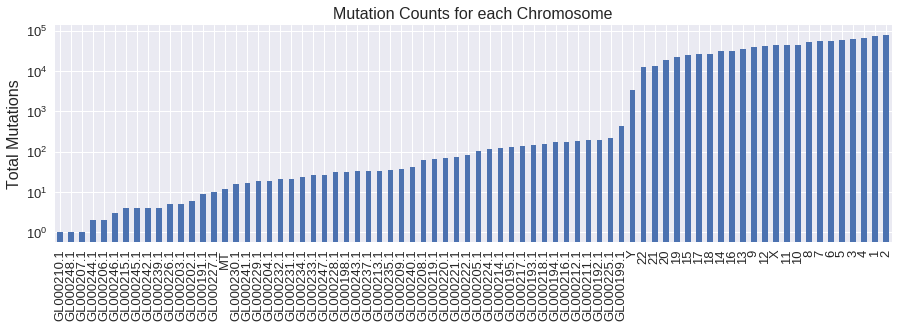

In [12]:
tot = pd.Series( chrMutTotal, index=chrList)

plt.figure( figsize=(15,4))
tot.sort_values().plot( kind='bar')

fs = 16
xt = range( len(tot))
xl = [ u for u in tot.sort_values().index]
plt.title('Mutation Counts for each Chromosome', fontsize=fs)
plt.ylabel('Total Mutations', fontsize=fs)
plt.xticks( xt, xl, rotation=90, fontsize=fs-3)
plt.yscale('log')
plt.yticks( fontsize=fs-3)
# plt.savefig('mutations_total_1.png', dpi=100)

Next, I am interested in investigating the mutation density across chromosomes. Chromosomes vary in size, so the mutation density allows us to better understand where there are significantly high concentrations of mutations. High mutation densities may be an indicator that the colorectal cancer is driving a lot of mutations at this part of the DNA.

In order to calculate mutation density we need to know the length of each chromosome. The mutation locations are relative to human reference hg19, and so I will get the chromosome lengths from the hg19 data off of the [UCSC genome browser](http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes) to calculate the densities.

In [14]:
hg19_chrLength = pd.read_table( 'hg19_chr_sizes.txt', header=None, names=[ 'chr', 'length'], low_memory=False)
print 'Chromosome length data set has %s rows and %s columns.' %(hg19_chrLength.shape)
hg19_chrLength.head()

Chromosome length data set has 93 rows and 2 columns.


,chr,length
0,chr1,249250621
1,chr2,243199373
2,chr3,198022430
3,chr4,191154276
4,chr5,180915260


In [16]:
hg19_chrLength.chr = hg19_chrLength.chr.astype(str)
# remove chr from beginning of chromosome names
hg19_chrLength.chr = hg19_chrLength.chr.str.lstrip('chr')
# remove 'Un_' and '_random'
hg19_chrLength.chr = hg19_chrLength.chr.str.lstrip('Un')
hg19_chrLength.chr = hg19_chrLength.chr.str.rstrip('_random')
# remove chromosome number from the beginning of non-regular chromosome names
for name in hg19_chrLength.chr:
    if '_gl' in name:
        x = name.find('_')
        hg19_chrLength.chr.loc[ hg19_chrLength.chr == name] = name[(x+1):] + '.1'
# make all characters uppercase
hg19_chrLength.chr = hg19_chrLength.chr.str.upper()
# change M to MT
hg19_chrLength.chr.loc[ hg19_chrLength.chr == 'M'] = 'MT'

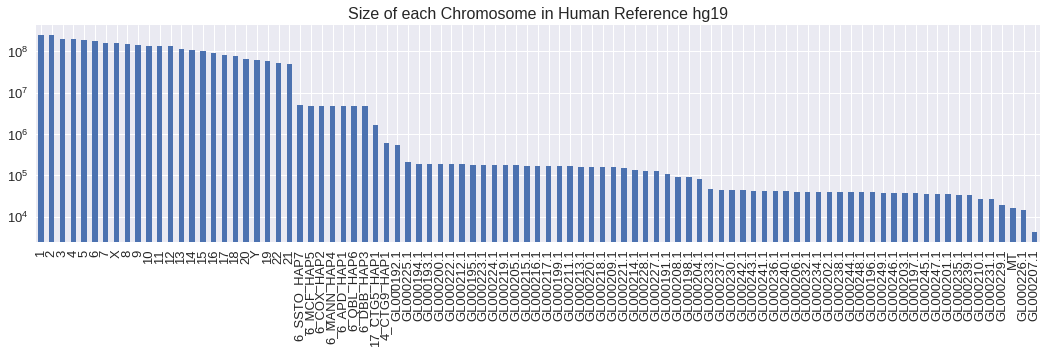

In [19]:
fs = 16
plt.figure( figsize=(18,4))
plt.title('Size of each Chromosome in Human Reference hg19', fontsize=fs)
hg19_chrLength.length.plot( kind='bar')
plt.xticks( range(len(hg19_chrLength)), hg19_chrLength.chr, fontsize=fs-3);
plt.yscale('log');
plt.yticks( fontsize=fs-3);

In [23]:
chrMutDensity = []
for i, name in enumerate(chrList):
    chrMutDensity.append( chrMutTotal[i] / float( hg19_chrLength.length[ hg19_chrLength.chr == name]) )

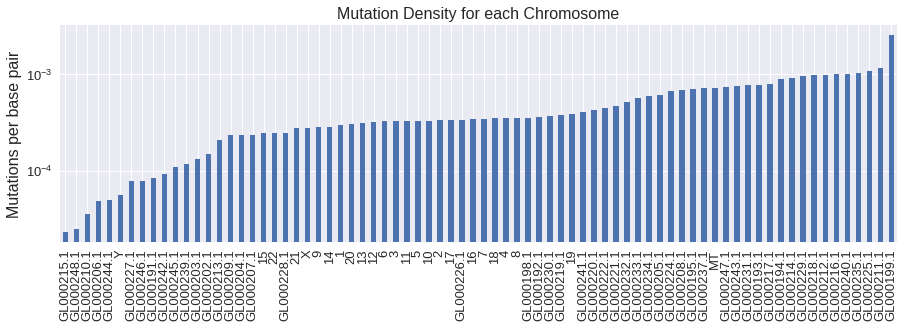

In [24]:
den = pd.Series( chrMutDensity, index=chrList)

plt.figure( figsize=(15,4))
plt.title('Mutation Density for each Chromosome')
den.sort_values().plot( kind='bar')

fs = 16
xt = range( len(tot))
xl = [ u for u in den.sort_values().index]
plt.title('Mutation Density for each Chromosome', fontsize=fs)
plt.ylabel('Mutations per base pair', fontsize=fs)
plt.yscale('log')
plt.xticks( xt, xl, rotation=90, fontsize=fs-3)
plt.yticks( fontsize=fs-3)
plt.yscale('log')
# plt.savefig('mutations_density_1.png', dpi=100)